In [1]:
#Eddie Costantini~Pitch Prediction Problem for Swish Analytics
#import packages

import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#utilizing Tensorflow-gpu backend

C:\Users\Eddie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
seed = 0
np.random.seed(seed)

In [4]:
#import data set
file = 'clean_pitch_data.csv'
dfIn = pd.read_csv(file)

#drop first column
dfIn=dfIn.drop(dfIn.columns[0], axis=1)
df=dfIn

[Text(0,0.5,'Each Type Pitchcount')]

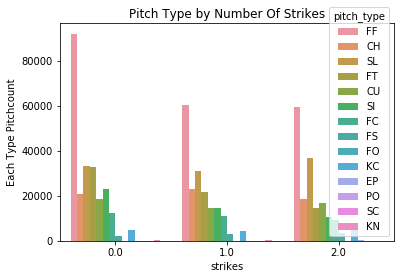

In [5]:
dfVis=df
ax = sns.countplot(x="strikes", hue="pitch_type", data=dfVis)
ax.set_title("Pitch Type by Number Of Strikes")
ax.set(ylabel="Each Type Pitchcount")

[Text(0,0.5,'Each Type Pitchcount')]

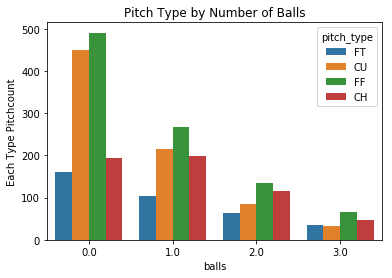

In [6]:
#particular pitcher
dfVis=df.loc[df['player_name']=='Aaron Nola']
ax = sns.countplot(x="balls", hue="pitch_type", data=dfVis)
ax.set_title("Pitch Type by Number of Balls")
ax.set(ylabel="Each Type Pitchcount")

[Text(0,0.5,'Each Type Pitchcount')]

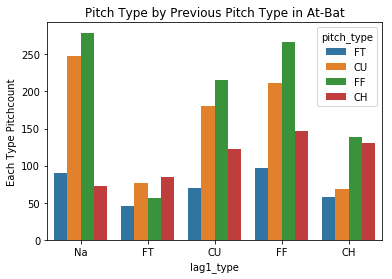

In [7]:
#dfVis=df
dfVis=df.loc[df['player_name']=='Aaron Nola']
ax = sns.countplot(x="lag1_type", hue="pitch_type", data=dfVis)
ax.set_title("Aaron Nola Pitch Type by Previous Pitch Type in At-Bat")
ax.set(ylabel="Each Type Pitchcount")
#Na pitch type is first pitch of atbat

In [8]:
#impute missing lag_x and lag_z values with mean
df['lag1_x']=df['lag1_x'].fillna(df['lag1_x'].mean())
df['lag1_z']=df['lag1_z'].fillna(df['lag1_z'].mean())
df['lag2_x']=df['lag2_x'].fillna(df['lag2_x'].mean())
df['lag2_z']=df['lag2_z'].fillna(df['lag2_z'].mean())
df['lag3_x']=df['lag3_x'].fillna(df['lag3_x'].mean())
df['lag3_z']=df['lag3_z'].fillna(df['lag3_z'].mean())

In [9]:
def encodeColumn(col):
    encoder = LabelEncoder()
    encoder.fit(col)
    encoded_col = encoder.transform(col)
    
    # convert integers to dummy variables (i.e. one hot encoded)
    dummy_col = np_utils.to_categorical(encoded_col)
    
    return (dummy_col, encoder)

In [10]:
#split into different dataframes, then convert to values for OHEC/prep
#no transformation needed for dfA
df_a= df[['balls','strikes','outs_when_up','inning','at_bat_number','pitch_number',
          'on_1','on_2','on_3','same_hand','score_diff',
          'lag1_x','lag1_z', 'lag2_x','lag2_z', 'lag3_x','lag3_z']]

data_a=df_a.values
X_a=data_a.astype(float)
        
#batter, pitcher, lag_type, lag_zone, lag_outcome
X_batter = df['batter'].values
X_pitcher = df['pitcher'].values

X_lag1type = df['lag1_type'].values
X_lag1zone = df['lag1_zone'].values
X_lag1outcome = df['lag1_outcome'].values

X_lag2type = df['lag2_type'].values
X_lag2zone = df['lag2_zone'].values
X_lag2outcome = df['lag2_outcome'].values

X_lag3type = df['lag3_type'].values
X_lag3zone = df['lag3_zone'].values
X_lag3outcome = df['lag3_outcome'].values

Y = df['pitch_type'].values

In [11]:
#column encoding for categorical X variables
dummy_x_batter, encoder_x_batter= encodeColumn(X_batter)
dummy_x_pitcher, encoder_x_pitcher= encodeColumn(X_pitcher)

dummy_x_lag1type = pd.get_dummies(X_lag1type)
dummy_x_lag1zone = pd.get_dummies(X_lag1zone)
dummy_x_lag1outcome = pd.get_dummies(X_lag1outcome)

dummy_x_lag2type = pd.get_dummies(X_lag2type)
dummy_x_lag2zone = pd.get_dummies(X_lag2zone)
dummy_x_lag2outcome = pd.get_dummies(X_lag2outcome)

dummy_x_lag3type = pd.get_dummies(X_lag3type)
dummy_x_lag3zone = pd.get_dummies(X_lag3zone)
dummy_x_lag3outcome = pd.get_dummies(X_lag3outcome)

In [12]:
#encode Y
dummy_y = pd.get_dummies(Y)
dummy_y.shape

(600834, 14)

In [31]:
def buildModel(X,Y,hidden):
    inputs=X.shape[1]
    outputs=Y.shape[1]

    model = Sequential()
    model.add(Dense(hidden, input_dim=inputs, activation='relu')) #variable inputs, 50 hidden neurons
    model.add(Dense(outputs, activation='softmax')) #15 possible pitch types
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit model
    print('start fit')
    model.fit(X, Y, epochs=5)
    return model

In [13]:
#create X dataset
X=np.concatenate((X_a,dummy_x_batter,dummy_x_pitcher,dummy_x_lag1type),axis=1)

In [19]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size = 0.2, random_state = 0)

model=buildModel(X_train,y_train,50)

done split
(480667, 1726)
start fit
Epoch 1/5
480667/480667 [==============================] - 65s 136us/step - loss: 1.2573 - acc: 0.4758
Epoch 2/5
480667/480667 [==============================] - 57s 119us/step - loss: 1.1396 - acc: 0.4956
Epoch 3/5
480667/480667 [==============================] - 58s 120us/step - loss: 1.1139 - acc: 0.5042
Epoch 4/5
480667/480667 [==============================] - 58s 121us/step - loss: 1.0987 - acc: 0.5103
Epoch 5/5
480667/480667 [==============================] - 57s 118us/step - loss: 1.0886 - acc: 0.5139


The model utilizes 1726 input neurons
-Uses 1 hidden layer with 50 hidden neurons (determined by upperbound:
Nh=Ns/(A*(Ni+No) with A=5)
-Outputs 18 neurons (1 per each pitch_type) in softmax format

In [20]:
#save the entirety of the model
model.save('pitch_prediction_model_type.h5')

In [21]:
#adding in zone variable
X2=np.concatenate((X,dummy_x_lag1zone),axis=1)
X2_train, X_2test, y2_train, y2_test = train_test_split(X2, dummy_y, test_size = 0.2, random_state = 0)


In [23]:
model2=buildModel(X2_train,y2_train,50)

#save the entirety of the model
model2.save('pitch_prediction_model_zone.h5')

done split
(480667, 1740)
start fit
Epoch 1/5
480667/480667 [==============================] - 80s 167us/step - loss: 1.2612 - acc: 0.4756
Epoch 2/5
480667/480667 [==============================] - 59s 122us/step - loss: 1.1414 - acc: 0.4948
Epoch 3/5
480667/480667 [==============================] - 60s 124us/step - loss: 1.1191 - acc: 0.5022
Epoch 4/5
480667/480667 [==============================] - 57s 118us/step - loss: 1.1051 - acc: 0.5086
Epoch 5/5
480667/480667 [==============================] - 60s 124us/step - loss: 1.0950 - acc: 0.5126


In [24]:
#adding lag1outcome
X3=np.concatenate((X2,dummy_x_lag1outcome),axis=1)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, dummy_y, test_size = 0.2, random_state = 0)


In [25]:
model3=buildModel(X3_train,y3_train,50)
#save the entirety of the model
model3.save('pitch_prediction_model_outcome.h5')

done split
(480667, 1744)
start fit
Epoch 1/5
  1344/480667 [..............................] - ETA: 1:36:41 - loss: 2.4092 - acc: 0.2426

C:\Users\Eddie\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.468973). Check your callbacks.
  % delta_t_median)


480667/480667 [==============================] - 75s 156us/step - loss: 1.2618 - acc: 0.4753
Epoch 2/5
480667/480667 [==============================] - 59s 122us/step - loss: 1.1440 - acc: 0.4946
Epoch 3/5
480667/480667 [==============================] - 58s 120us/step - loss: 1.1184 - acc: 0.5042
Epoch 4/5
480667/480667 [==============================] - 57s 120us/step - loss: 1.1030 - acc: 0.5101
Epoch 5/5
480667/480667 [==============================] - 58s 120us/step - loss: 1.0919 - acc: 0.5156


In [30]:
#adding lag2 variables
X4=np.concatenate((X3,dummy_x_lag2type,dummy_x_lag2zone,dummy_x_lag2outcome),axis=1)
X4_train, X4_test, y4_train, y4_test = train_test_split(X, dummy_y, test_size = 0.2, random_state = 0)


In [32]:
model4=buildModel(X4_train,y4_train,50)

#save the entirety of the model
model4.save('pitch_prediction_model_lag2.h5')

start fit
Epoch 1/5
480667/480667 [==============================] - 74s 155us/step - loss: 1.2596 - acc: 0.4749
Epoch 2/5
480667/480667 [==============================] - 69s 144us/step - loss: 1.1438 - acc: 0.4936
Epoch 3/5
480667/480667 [==============================] - 59s 123us/step - loss: 1.1209 - acc: 0.5012
Epoch 4/5
480667/480667 [==============================] - 59s 122us/step - loss: 1.1063 - acc: 0.5073
Epoch 5/5
480667/480667 [==============================] - 60s 124us/step - loss: 1.0955 - acc: 0.5126


In [33]:
# Predicting the Test set results
import sklearn
y_pred = model4.predict_proba(X4_test)

In [34]:
#for i in range(len(X_test)):
#print(list(encoder_y.classes_))
for i in range(0,1):
    #probability of each pitch type is printed as desired
    print((y_pred[i])) #format this as percentage

     

[3.8573346e-01 9.1279164e-02 9.7794998e-07 1.3355952e-03 4.6663200e-03
 3.6535820e-17 7.6039923e-06 4.6538096e-03 1.2112669e-04 7.4325829e-20
 2.9434039e-05 1.9436194e-04 3.7570563e-01 1.3627258e-01]


Performance:
Performance should be measured by the difference between my model and a naive model, the naive model simply predicting each individual pitcher's most thrown pitch_type.

Future Steps:
3) Catchers are calling the game and their ID should be added to the dataset. I suspect that less-stellar defensive catchers will not call for as many breaking pitches with runners on base.

2) Location/weather data is likely relevant as well, pitchers are less likely to throw breaking pitches in high altitude/dry days

3) Team codes

4) Formatting output for clarity


Thank you for reviewing my submission. I invite you to check out my fantasy baseball draft optimization code on github as well: https://github.com/CostaCostaCosta/Fantasy-Baseball-Draft-Optimization
